# Combined Demand Signal Analysis

**Business Question:** Which brands should a footwear retailer prioritize for production investment, channel allocation, and marketing spend — right now?

This notebook bridges two independent data systems into one decision surface:

| System | Source | Signal |
|--------|--------|--------|
| **[sneaker-intel](https://github.com/hyunstar11/sneaker-intel)** | Market 2023 (1,994 products, 23 brands) | Aftermarket demand: resale premium, deadstock volume, volatility |
| **[reddit-sentiment](https://github.com/hyunstar11/reddit-sentiment)** | Reddit (5,796 posts + comments, 9 subreddits) | Consumer narrative: brand sentiment, purchase intent, channel attribution |

**Why combine them?** Aftermarket data tells you *how strong demand was*. Reddit tells you *what consumers are saying right now*. Together they answer: does the historical demand signal have forward-looking confirmation — or is sentiment diverging from fundamentals?

```
sneaker-intel  →  demand tier, price premium, market liquidity
                          ↘
                    Combined Signal Matrix
                          ↗
reddit-sentiment →  brand sentiment, purchase intent, channel flow
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

# Paths
PORTFOLIO_ROOT = Path('.').resolve()           # CWD = Portfolio/ when run via papermill
REDDIT_DATA    = PORTFOLIO_ROOT / 'reddit-sentiment' / 'data' / 'processed' / 'annotated.parquet'

# sneaker-intel is installed in this kernel's venv
from sneaker_intel.data import load_dataset, DatasetType
from sneaker_intel.visualization.style import apply_nike_style
apply_nike_style()

print(f'Portfolio root : {PORTFOLIO_ROOT}')
print(f'Reddit data    : {REDDIT_DATA.exists()}')

Portfolio root : /Users/khl/Desktop/Portfolio
Reddit data    : True


## 1. Aftermarket Demand Signal (sneaker-intel)

From the Market 2023 dataset: **median resale premium** (price above retail = unmet demand), **deadstock volume** (secondary market liquidity), and **volatility** (speculator interest).

Jordan is rolled into Nike since Jordan Brand is a Nike subsidiary — both map to Nike's demand planning function.

In [2]:
mkt = load_dataset(DatasetType.MARKET_2023)
mkt = mkt[np.isfinite(mkt['pricePremium'])].copy()

BRAND_MAP = {
    'Nike':        'Nike',
    'Jordan':      'Nike',          # Jordan Brand rolls up into Nike
    'adidas':      'Adidas',
    'New Balance': 'New Balance',
    'Puma':        'Puma',
    'ASICS':       'Asics',
}
mkt['brand_norm'] = mkt['brand'].map(BRAND_MAP)

demand = (
    mkt.dropna(subset=['brand_norm'])
    .groupby('brand_norm')
    .agg(
        products         = ('item',          'count'),
        median_premium   = ('pricePremium',  'median'),
        total_deadstock  = ('deadstockSold', 'sum'),
        avg_volatility   = ('volatility',    'mean'),
        median_bids      = ('numberOfBids',  'median'),
    )
    .reset_index()
    .rename(columns={'brand_norm': 'brand'})
)

print('Aftermarket demand by brand:')
print(demand.set_index('brand').round(3).to_string())

Aftermarket demand by brand:
             products  median_premium  total_deadstock  avg_volatility  median_bids
brand                                                                              
Adidas            231           0.307          2224577           0.133        157.0
Asics               3           0.129              925           0.177         53.0
New Balance       134           0.218           386789           0.144        119.0
Nike             1543           0.177          9667915           0.131        147.0
Puma               14           0.450            41542           0.146         71.5


## 2. Consumer Sentiment Signal (reddit-sentiment)

From 5,796 Reddit posts + comments across 9 sneaker subreddits (Feb 2026): **brand mention volume**, **hybrid sentiment score** (60% Twitter-RoBERTa + 40% VADER on brand-context windows), and **purchase intent breakdown**.

Only brands with ≥ 5 mentions are included to avoid noise.

In [3]:
rs = pd.read_parquet(REDDIT_DATA)
rs['brands']   = rs['brands'].apply(lambda x: list(x) if hasattr(x, '__iter__') and not isinstance(x, str) else [])
rs['channels'] = rs['channels'].apply(lambda x: list(x) if hasattr(x, '__iter__') and not isinstance(x, str) else [])

rs_exp = rs.explode('brands').dropna(subset=['brands'])
rs_exp = rs_exp[rs_exp['brands'].str.len() > 0]

THRESHOLD = 0.05   # VADER/hybrid boundary for pos/neg

sentiment = (
    rs_exp.groupby('brands')
    .agg(
        mentions        = ('hybrid_score', 'count'),
        avg_sentiment   = ('hybrid_score', 'mean'),
        positive_pct    = ('hybrid_score', lambda x: (x >  THRESHOLD).mean() * 100),
        negative_pct    = ('hybrid_score', lambda x: (x < -THRESHOLD).mean() * 100),
        seeking         = ('primary_intent', lambda x: (x == 'seeking_purchase').sum()),
        completed       = ('primary_intent', lambda x: (x == 'completed_purchase').sum()),
        marketplace     = ('primary_intent', lambda x: (x == 'marketplace').sum()),
    )
    .reset_index()
    .rename(columns={'brands': 'brand'})
)
sentiment = sentiment[sentiment['mentions'] >= 5].copy()

print('Reddit sentiment by brand:')
print(sentiment.set_index('brand').round(3).to_string())

Reddit sentiment by brand:
             mentions  avg_sentiment  positive_pct  negative_pct  seeking  completed  marketplace
brand                                                                                            
Adidas            266          0.257        52.256        19.925        3          9           20
Asics               8          0.387        62.500         0.000        0          1            4
Li-Ning            38          0.691        92.105         5.263        1          2            0
New Balance        38          0.161        52.632        23.684        1          2           26
Nike              627          0.201        50.239        22.648        4         16          194
Puma                6          0.377        83.333         0.000        1          1            0


## 3. Combined Signal Matrix

Join both signals on brand. The resulting table surfaces where quantitative demand and qualitative sentiment **agree** (strong buy signal) or **diverge** (risk signal requiring investigation).

In [4]:
combined = demand.merge(sentiment, on='brand', how='inner')

# Quadrant classification
med_premium   = combined['median_premium'].median()
med_sentiment = combined['avg_sentiment'].median()

def classify(row):
    high_demand    = row['median_premium']  >= med_premium
    high_sentiment = row['avg_sentiment']   >= med_sentiment
    if high_demand and high_sentiment:
        return 'Scale Up'
    elif high_demand and not high_sentiment:
        return 'Investigate'
    elif not high_demand and high_sentiment:
        return 'Emerging'
    else:
        return 'Deprioritize'

combined['signal'] = combined.apply(classify, axis=1)

display_cols = ['brand', 'median_premium', 'total_deadstock', 'mentions',
                'avg_sentiment', 'positive_pct', 'seeking', 'signal']
print('Combined Signal Matrix:')
print(combined[display_cols].set_index('brand').round(3).to_string())

Combined Signal Matrix:
             median_premium  total_deadstock  mentions  avg_sentiment  positive_pct  seeking        signal
brand                                                                                                     
Adidas                0.307          2224577       266          0.257        52.256        3      Scale Up
Asics                 0.129              925         8          0.387        62.500        0      Emerging
New Balance           0.218           386789        38          0.161        52.632        1   Investigate
Nike                  0.177          9667915       627          0.201        50.239        4  Deprioritize
Puma                  0.450            41542         6          0.377        83.333        1      Scale Up


## 4. Signal Quadrant — The Decision Chart

**X-axis:** Median resale premium (aftermarket demand strength from sneaker-intel)  
**Y-axis:** Average Reddit sentiment score (consumer narrative from reddit-sentiment)  
**Bubble size:** Reddit mention volume (signal strength / community attention)  

Quadrant logic:
- **Top-right (Scale Up):** High demand + positive narrative → increase allocation, protect Nike Direct supply
- **Top-left (Emerging):** Strong sentiment, softer aftermarket → watch for breakout; early marketing investment
- **Bottom-right (Investigate):** Strong aftermarket but narrative headwinds → risk of authenticity/quality backlash
- **Bottom-left (Deprioritize):** Weak on both dimensions → minimal incremental investment

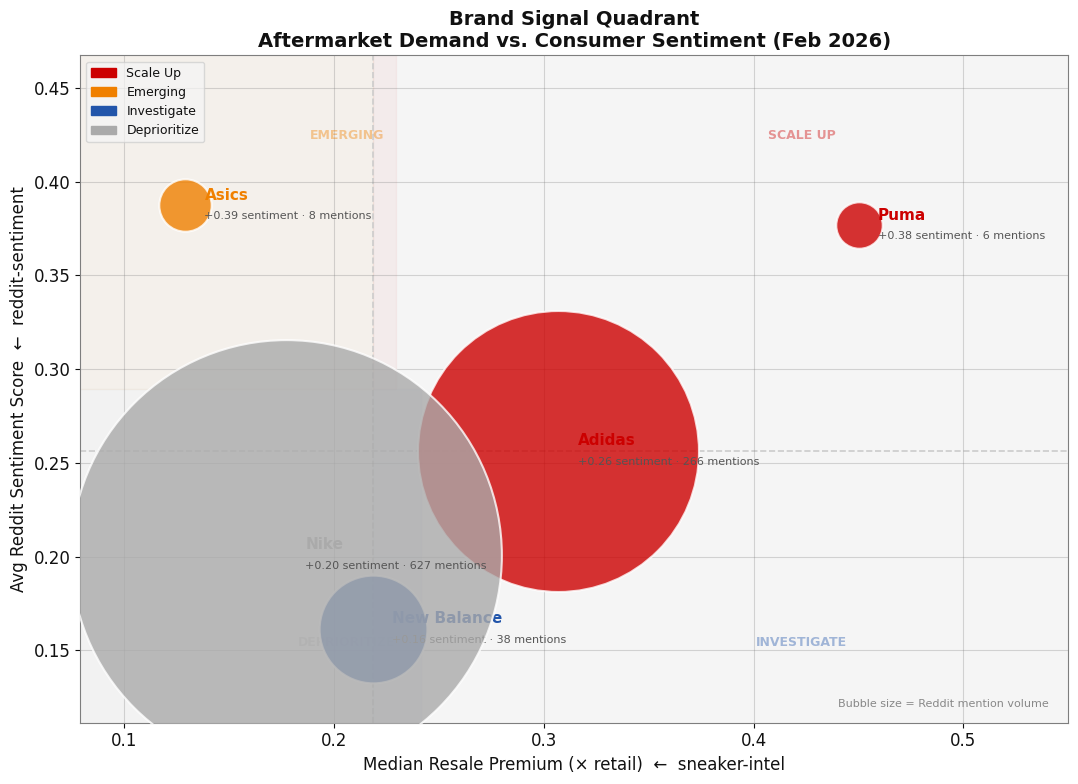


Signal classification:
                   signal  median_premium  avg_sentiment  mentions
brand                                                             
Adidas           Scale Up          0.3070       0.256556       266
Asics            Emerging          0.1290       0.387412         8
New Balance   Investigate          0.2185       0.161429        38
Nike         Deprioritize          0.1770       0.200966       627
Puma             Scale Up          0.4500       0.376733         6


In [5]:
QUAD_COLORS = {
    'Scale Up':     '#CC0000',
    'Emerging':     '#F08000',
    'Investigate':  '#2255AA',
    'Deprioritize': '#AAAAAA',
}

fig, ax = plt.subplots(figsize=(11, 8))

# Quadrant shading
ax.axvspan(ax.get_xlim()[0], med_premium,   ymin=0.5, ymax=1.0, alpha=0.04, color='#F08000')
ax.axvspan(med_premium,      ax.get_xlim()[1], ymin=0.5, ymax=1.0, alpha=0.04, color='#CC0000')
ax.axvspan(ax.get_xlim()[0], med_premium,   ymin=0.0, ymax=0.5, alpha=0.04, color='#AAAAAA')
ax.axvspan(med_premium,      ax.get_xlim()[1], ymin=0.0, ymax=0.5, alpha=0.04, color='#2255AA')

# Dividers
ax.axvline(med_premium,   color='#cccccc', linestyle='--', lw=1.2, zorder=1)
ax.axhline(med_sentiment, color='#cccccc', linestyle='--', lw=1.2, zorder=1)

# Quadrant labels
xlim = (combined['median_premium'].min() - 0.05, combined['median_premium'].max() + 0.1)
ylim = (combined['avg_sentiment'].min()  - 0.05, combined['avg_sentiment'].max()  + 0.08)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

for label, x_frac, y_frac, color in [
    ('SCALE UP',     0.73, 0.88, '#CC0000'),
    ('EMERGING',     0.27, 0.88, '#F08000'),
    ('INVESTIGATE',  0.73, 0.12, '#2255AA'),
    ('DEPRIORITIZE', 0.27, 0.12, '#AAAAAA'),
]:
    ax.text(xlim[0] + x_frac * (xlim[1]-xlim[0]),
            ylim[0] + y_frac * (ylim[1]-ylim[0]),
            label, ha='center', va='center', fontsize=9,
            fontweight='bold', color=color, alpha=0.4)

# Bubbles
bubble_scale = 120
for _, row in combined.iterrows():
    color  = QUAD_COLORS[row['signal']]
    size   = row['mentions'] * bubble_scale / combined['mentions'].max() * 800 + 200
    ax.scatter(row['median_premium'], row['avg_sentiment'],
               s=size, color=color, alpha=0.80,
               edgecolors='white', linewidth=1.5, zorder=3)
    ax.annotate(
        row['brand'],
        (row['median_premium'], row['avg_sentiment']),
        xytext=(14, 4), textcoords='offset points',
        fontsize=11, fontweight='bold', color=color,
    )
    # Show key stats below brand name
    ax.annotate(
        f"+{row['avg_sentiment']:.2f} sentiment · {row['mentions']} mentions",
        (row['median_premium'], row['avg_sentiment']),
        xytext=(14, -10), textcoords='offset points',
        fontsize=8, color='#555555',
    )

ax.set_xlabel('Median Resale Premium (× retail)  ←  sneaker-intel', fontsize=12)
ax.set_ylabel('Avg Reddit Sentiment Score  ←  reddit-sentiment', fontsize=12)
ax.set_title(
    'Brand Signal Quadrant\nAftermarket Demand vs. Consumer Sentiment (Feb 2026)',
    fontsize=14, fontweight='bold'
)
ax.text(0.98, 0.02, 'Bubble size = Reddit mention volume',
        transform=ax.transAxes, ha='right', va='bottom', fontsize=8, color='#888888')

legend_patches = [mpatches.Patch(color=c, label=l) for l, c in QUAD_COLORS.items()]
ax.legend(handles=legend_patches, loc='upper left', fontsize=9, framealpha=0.7)

plt.tight_layout()
plt.show()

print('\nSignal classification:')
print(combined[['brand','signal','median_premium','avg_sentiment','mentions']].set_index('brand').to_string())

## 5. Purchase Intent Breakdown by Brand

Sentiment tells us *tone*. Intent tells us *action*. `seeking_purchase` ("W2C", "where to cop") is the highest-value signal — it represents active demand that hasn't yet converted to a transaction.

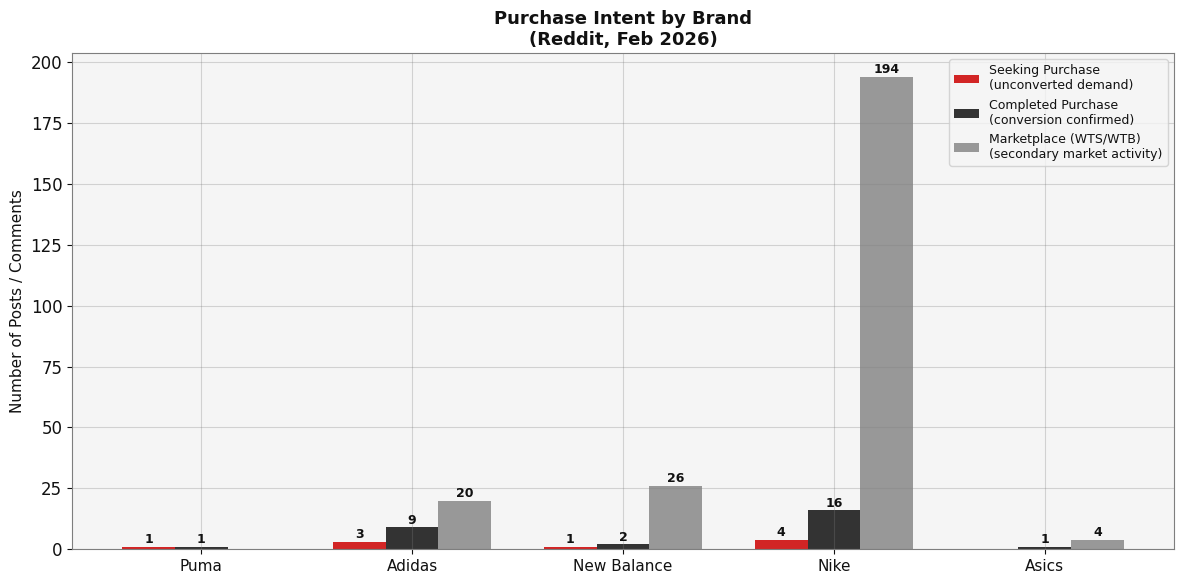

Seek-to-complete ratio (higher = more unconverted demand):
             seeking  completed  seek_to_complete
brand                                            
Adidas             3          9              0.33
Asics              0          1              0.00
New Balance        1          2              0.50
Nike               4         16              0.25
Puma               1          1              1.00


In [6]:
intent_order = ['seeking', 'completed', 'marketplace']
intent_labels = {
    'seeking':     'Seeking Purchase\n(unconverted demand)',
    'completed':   'Completed Purchase\n(conversion confirmed)',
    'marketplace': 'Marketplace (WTS/WTB)\n(secondary market activity)',
}

brands_sorted = combined.sort_values('median_premium', ascending=False)['brand'].tolist()

x      = np.arange(len(brands_sorted))
width  = 0.25
colors = ['#CC0000', '#111111', '#888888']

fig, ax = plt.subplots(figsize=(12, 6))

for i, (intent, color) in enumerate(zip(intent_order, colors)):
    vals = [combined.loc[combined['brand'] == b, intent].values[0] for b in brands_sorted]
    bars = ax.bar(x + i * width, vals, width, label=intent_labels[intent], color=color, alpha=0.85)
    for bar, val in zip(bars, vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                    str(int(val)), ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(x + width)
ax.set_xticklabels(brands_sorted, fontsize=11)
ax.set_ylabel('Number of Posts / Comments', fontsize=11)
ax.set_title('Purchase Intent by Brand\n(Reddit, Feb 2026)', fontsize=13, fontweight='bold')
ax.legend(fontsize=9, loc='upper right')
plt.tight_layout()
plt.show()

# Seek-to-complete ratio
combined['seek_to_complete'] = combined.apply(
    lambda r: r['seeking'] / r['completed'] if r['completed'] > 0 else float('inf'), axis=1
)
print('Seek-to-complete ratio (higher = more unconverted demand):')
print(combined[['brand','seeking','completed','seek_to_complete']].set_index('brand').round(2).to_string())

## 6. Channel Attribution by Brand

Where are consumers being directed when they discuss each brand? This surfaces whether demand is flowing toward **DTC channels** (Nike Direct, SNKRS — higher margin) or **third-party secondary markets** (StockX, GOAT, eBay — margin leakage).

In [7]:
# Explode channels alongside brands for per-brand channel attribution
rs_brand_channel = (
    rs.explode('brands')
    .dropna(subset=['brands'])
    .query('brands.str.len() > 0', engine='python')
    .explode('channels')
    .dropna(subset=['channels'])
    .query('channels.str.len() > 0', engine='python')
)

# Filter to brands in our combined set
rs_brand_channel = rs_brand_channel[rs_brand_channel['brands'].isin(combined['brand'])]

channel_summary = (
    rs_brand_channel.groupby(['brands', 'channels'])
    .size()
    .reset_index(name='count')
    .sort_values(['brands', 'count'], ascending=[True, False])
)

# Top 3 channels per brand
top_channels = (
    channel_summary
    .groupby('brands')
    .head(3)
    .reset_index(drop=True)
)

# Pivot for display
top_channels['rank'] = top_channels.groupby('brands').cumcount() + 1
channel_pivot = top_channels.pivot(index='brands', columns='rank', values='channels').rename(
    columns={1: 'Top Channel', 2: '2nd Channel', 3: '3rd Channel'}
)

# Add mention counts
channel_counts = top_channels.pivot(index='brands', columns='rank', values='count').rename(
    columns={1: 'Top (n)', 2: '2nd (n)', 3: '3rd (n)'}
)

result = pd.concat([channel_pivot, channel_counts], axis=1)
col_order = ['Top Channel', 'Top (n)', '2nd Channel', '2nd (n)', '3rd Channel', '3rd (n)']
print('Top 3 retail channels per brand (Reddit mentions):')
print(result[[c for c in col_order if c in result.columns]].fillna('-').to_string())

Top 3 retail channels per brand (Reddit mentions):
rank         Top Channel  Top (n) 2nd Channel  2nd (n) 3rd Channel 3rd (n)
brands                                                                    
Adidas              eBay     10.0     Grailed      2.0      Amazon     1.0
Asics        Flight Club      1.0        Kith      1.0           -       -
New Balance         Kith      6.0  Undefeated      2.0      Bodega     1.0
Nike                eBay     12.0  Undefeated     10.0      StockX     7.0


## 7. Strategic Recommendations

Translating the combined signal into action items for each brand — the kind of output a demand planner or merchandising team would actually use.

In [8]:
PLAYBOOKS = {
    'Scale Up': (
        'High aftermarket demand + positive consumer narrative. '
        'Increase production allocation. Prioritize DTC/Nike Direct to capture margin. '
        'Hold restock ≥ 60 days to maintain secondary market price health.'
    ),
    'Emerging': (
        'Strong consumer buzz but softer aftermarket traction. '
        'Early-stage brand heat — increase seeding and influencer allocation. '
        'Monitor for breakout; do not over-produce until aftermarket confirms demand.'
    ),
    'Investigate': (
        'Strong aftermarket demand but sentiment headwinds. '
        'Dig into negative narrative themes — quality, authenticity, or pricing perception issues. '
        'Maintain supply discipline; address narrative before scaling production.'
    ),
    'Deprioritize': (
        'Below-median on both dimensions. '
        'Minimal incremental investment. Re-evaluate at next data refresh.'
    ),
}

recs = []
for _, row in combined.sort_values('median_premium', ascending=False).iterrows():
    # Get top channel for this brand
    brand_channels = channel_summary[channel_summary['brands'] == row['brand']]
    top_ch = brand_channels.iloc[0]['channels'] if len(brand_channels) > 0 else 'N/A'

    recs.append({
        'Brand':           row['brand'],
        'Signal':          row['signal'],
        'Resale Premium':  f"{row['median_premium']:.2f}x",
        'Sentiment':       f"+{row['avg_sentiment']:.3f}",
        'Reddit Mentions': int(row['mentions']),
        'Top Channel':     top_ch,
        'Action':          PLAYBOOKS[row['signal']],
    })

rec_df = pd.DataFrame(recs).set_index('Brand')

pd.set_option('display.max_colwidth', 110)
print('=' * 100)
print('COMBINED SIGNAL PLAYBOOK — BRAND RECOMMENDATIONS')
print('=' * 100)
for brand, row in rec_df.iterrows():
    print(f"\n{brand}  [{row['Signal']}]")
    print(f"  Aftermarket: {row['Resale Premium']} resale premium  |  Sentiment: {row['Sentiment']}  "
          f"|  {row['Reddit Mentions']} Reddit mentions  |  Top channel: {row['Top Channel']}")
    print(f"  → {row['Action']}")
print('\n' + '=' * 100)

COMBINED SIGNAL PLAYBOOK — BRAND RECOMMENDATIONS

Puma  [Scale Up]
  Aftermarket: 0.45x resale premium  |  Sentiment: +0.377  |  6 Reddit mentions  |  Top channel: N/A
  → High aftermarket demand + positive consumer narrative. Increase production allocation. Prioritize DTC/Nike Direct to capture margin. Hold restock ≥ 60 days to maintain secondary market price health.

Adidas  [Scale Up]
  Aftermarket: 0.31x resale premium  |  Sentiment: +0.257  |  266 Reddit mentions  |  Top channel: eBay
  → High aftermarket demand + positive consumer narrative. Increase production allocation. Prioritize DTC/Nike Direct to capture margin. Hold restock ≥ 60 days to maintain secondary market price health.

New Balance  [Investigate]
  Aftermarket: 0.22x resale premium  |  Sentiment: +0.161  |  38 Reddit mentions  |  Top channel: Kith
  → Strong aftermarket demand but sentiment headwinds. Dig into negative narrative themes — quality, authenticity, or pricing perception issues. Maintain supply discipline